# Geospatial Python
## Raster Calculations in Python
Setup: https://carpentries-incubator.github.io/geospatial-python/index.html

Instruction: https://carpentries-incubator.github.io/geospatial-python/09-raster-calculations.html

Objectives:
* Carry out operations with two rasters using Python’s built-in math operators.
* Reclassify a continuous raster to a categorical raster.

We will use the results of the satellite image search 'search.json', which was generated in 'Raster Data Access.ipynb'.

In [1]:
# Import required libraries
import pystac # to load rasters from the search result
import rioxarray # to open and download remote raster data

import geojson # to parse spatial data format
import folium # to create an interactive map
from folium.plugins import Draw # to allow drawing

# Create a variable to determine if the notebook is being run locally
local_run=False
if local_run:
    # this package is problematic on remote computers
    from localtileserver import TileClient, get_folium_tile_layer # to visualize the geotiff

import numpy as np # to work with numbered lists
import xarray # to preserve spatial metadata when working with numbered lists

import earthpy.plot as ep # for drawing a legend
import matplotlib.pyplot as plt # for plotting
from matplotlib.colors import ListedColormap # to color our classified data

In [2]:
# Load the results of our initial imagery search using pystac
items = pystac.ItemCollection.from_file("search.json")

In [3]:
# Select the second item (index 0), and extract the URIs of the red and nir08 bands (“red” and “nir08”, respectively):
red_href = items[1].assets["red"].href
nir_href = items[1].assets["nir08"].href

In [4]:
# load the rasters with open_rasterio using the argument masked=True.
red = rioxarray.open_rasterio(red_href, masked=True)
nir = rioxarray.open_rasterio(nir_href, masked=True)

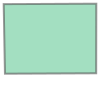

In [5]:
# Let's show the boundary box of the whole tiff on an interactive map
# Interactive maps generally expect data that's in CRS 4326
# We'll need to convert our boundary box to this CRS

# Some extra modules and a library are required for this
from shapely.geometry import box # To create a box
from shapely.ops import transform # The shapely transform module  
import pyproj # A reprojection library

# Create the transformer
project = pyproj.Transformer.from_crs(nir.rio.crs.to_epsg(), 4326, always_xy=True).transform

# Create our boundary box
bbox = box(*nir.rio.bounds())

# Apply the transformation
bbox_transformed = transform(project, bbox)

bbox_transformed

In [6]:
# Let's use an interctive map to create an area of interest (AOI) for use in subsetting our data. 

# Create a map object
m = folium.Map( zoom_start=12)

# Create tile client for our geotiff to and show it on the map
if local_run:
    nir_tiles = TileClient(nir_href) # create tiles client
    nir_layer = get_folium_tile_layer(nir_tiles, name='nir') # create elevation tile layer
    
    # Add our tiles
    nir_layer.add_to(m)

# show the boundary box of the whole tiff
folium.GeoJson(bbox_transformed,
    style_function=lambda feature: {
        "color": "red",
    }).add_to(m)

# Add drawing tools
draw = Draw(export=True)
draw.add_to(m)

# Add drawing controls
folium.LayerControl().add_to(m)

m

# Use the draw rectangle tool to create a shape that overlaps a portion of the boundary

In [7]:
# Copy the geojson from the drawn polygon (click the shape, and copy the text starting from '{"type":"Polygon"', up until the last '}').
geom ='''{"type":"Polygon","coordinates":[[[-106.020813,40.726446],[-106.020813,41.261291],[-105.227051,41.261291],[-105.227051,40.726446],[-106.020813,40.726446]]]}'''

geojson.loads(geom)
cropping_geometries = [geojson.loads(geom)] # converts to list

# Use the 'clip' method to crop the rasters. See Docs: https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-rio-accessors
red_clip = red.rio.clip(geometries=cropping_geometries, crs=4326)
nir_clip = nir.rio.clip(geometries=cropping_geometries, crs=4326)

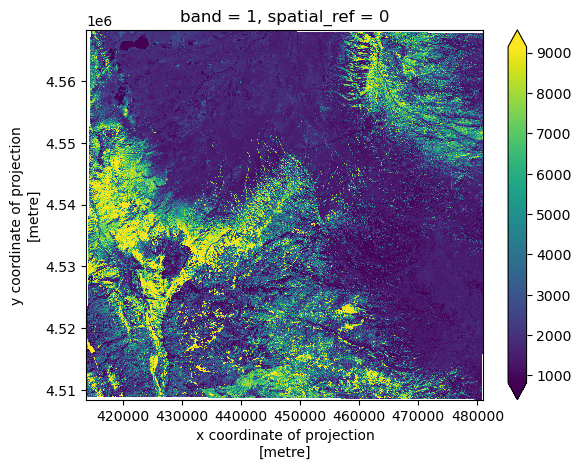

In [8]:
# plot the two rasters Using robust=True
red_clip.plot(robust=True)

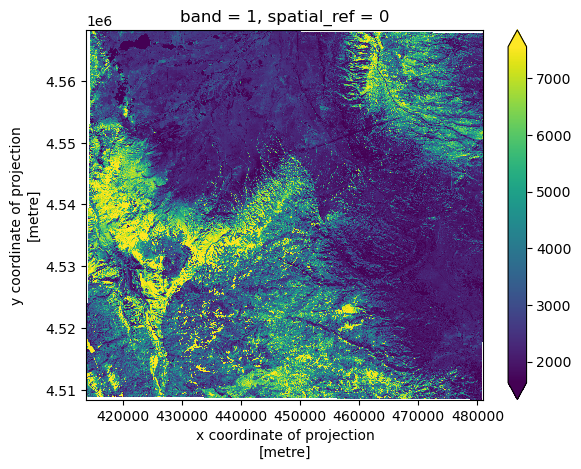

In [9]:
# plot the two rasters Using robust=True
nir_clip.plot(robust=True)

## Raster Math

In [10]:
#check the shapes of the two rasters in the following way
print(red_clip.shape, nir_clip.shape)

(1, 5985, 6719) (1, 2992, 3359)


In [11]:
# As their width and height do not match, use reproject_match to both reproject and clip a raster to the CRS and extent of another raster.
red_clip_matched = red_clip.rio.reproject_match(nir_clip,nodata=np.nan) # Set NaN as NoData
print(red_clip_matched.shape)

(1, 2992, 3359)


In [12]:
# Compute the NDVI to create a new raster 
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 2992, x: 3359)> Size: 40MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 27kB 4.138e+05 4.138e+05 ... 4.81e+05 4.81e+05
  * y            (y) float64 24kB 4.568e+06 4.568e+06 ... 4.508e+06 4.508e+06
    spatial_ref  int64 8B 0


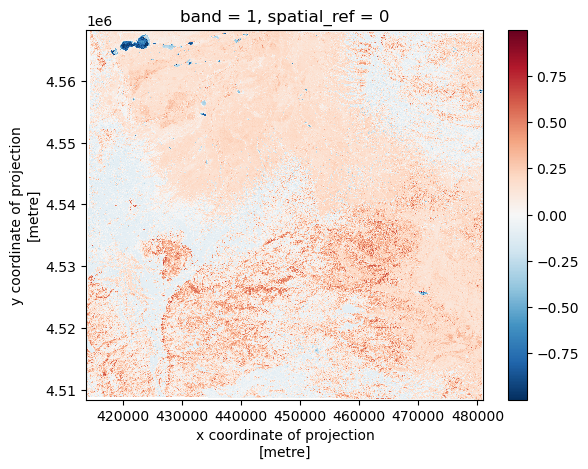

In [13]:
# Plot the output NDVI
ndvi.plot()

(array([2.199000e+03, 1.391000e+03, 1.697000e+03, 2.120000e+03,
        2.274000e+03, 2.152000e+03, 1.990000e+03, 1.748000e+03,
        1.467000e+03, 1.303000e+03, 1.053000e+03, 8.250000e+02,
        8.170000e+02, 9.260000e+02, 1.242000e+03, 2.072000e+03,
        3.797000e+03, 7.004000e+03, 1.067300e+04, 2.258000e+04,
        6.345800e+04, 2.049590e+05, 8.449010e+05, 6.917660e+05,
        5.547930e+05, 5.280430e+05, 5.676900e+05, 8.116040e+05,
        1.525729e+06, 1.758205e+06, 9.528500e+05, 4.316740e+05,
        2.783200e+05, 1.978350e+05, 1.431310e+05, 1.032510e+05,
        7.167600e+04, 4.868300e+04, 3.061500e+04, 1.751300e+04,
        8.290000e+03, 3.102000e+03, 9.860000e+02, 2.930000e+02,
        5.100000e+01, 1.400000e+01, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([-9.97493744e-01, -9.57559586e-01, -9.17625427e-01, -8.77691329e-01,
        -8.37757170e-01, -7.97823012e-01, -7.57888854e-01, -7.17954755e-01,
        -6.78020597e-01, -6.38086438e-01, 

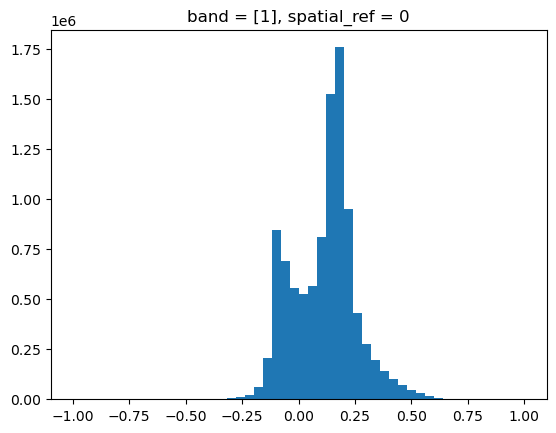

In [14]:
# Plot a histogram to see the spread of values accross 50 bins
ndvi.plot.hist(bins=50)

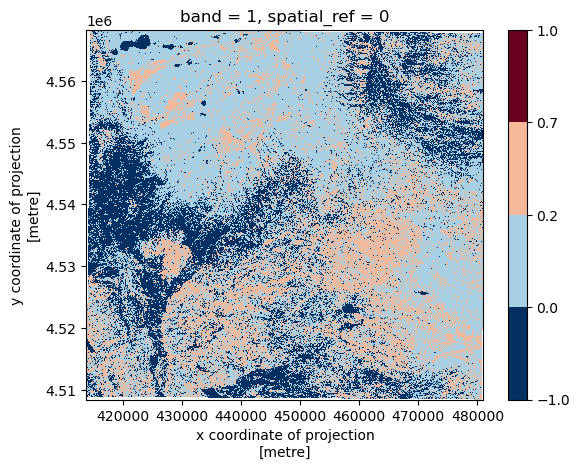

In [15]:
# Discretize the color plot by specifying the intervals
class_bins = (-1, 0., 0.2, 0.7, 1)
ndvi.plot(levels=class_bins)

In [16]:
# Missing values can be interpolated from the values of neighbouring grid cells using the .interpolate_na method. 
# ndvi_nonan = ndvi.interpolate_na(dim="x")

# # save the output
# ndvi_nonan.rio.to_raster("NDVI.tif")

## Classifying Continuous Rasters in Python

Reduce the complexity of the map by classifying it. 

Classification involves assigning each pixel in the raster to a class based on its value. 

In Python, we can accomplish this using the *numpy.digitize* function

Note: by default, each class includes the left but not the right bound. This is not an issue here, since the computed range of NDVI values are fully contained in the open interval (-1; 1)

In [17]:
# Define the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That won't work for us -- we need the coordinates and other spatial metadata. 
# We can get around this by using "xarray.apply_ufunc", 
# which can run the function across the data array while preserving the metadata.

ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi,#ndvi_nonan,
    class_bins,
    dataset_fill_value=np.nan
)

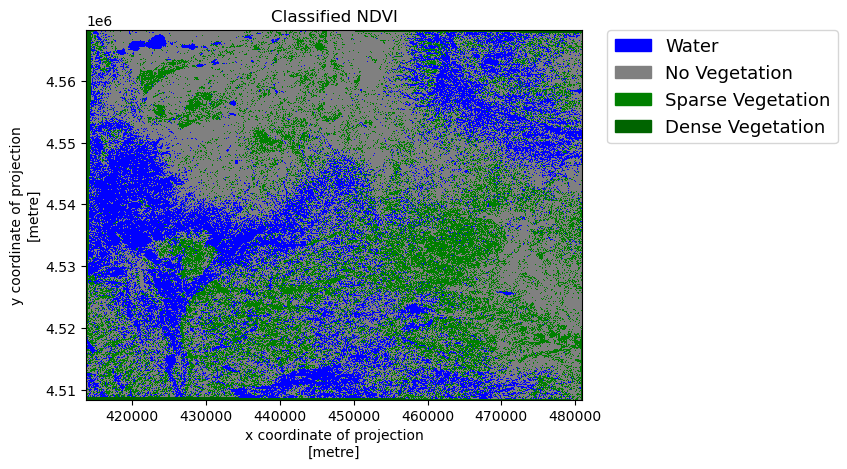

In [18]:
# Visualize the classified NDVI, customizing the plot with proper title and legend

# Define a color map for the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")

# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [19]:
# Export the classified NDVI raster object to a GeoTiff
ndvi_classified.rio.to_raster("NDVI_classified.tif", dtype="int32")

(array([2.416796e+06, 0.000000e+00, 5.182209e+06, 0.000000e+00,
        0.000000e+00, 2.309073e+06, 0.000000e+00, 6.890000e+02,
        0.000000e+00, 1.413610e+05]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

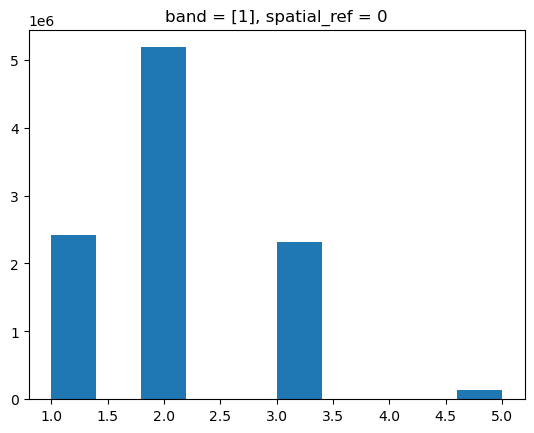

In [20]:
ndvi_classified.plot.hist()